In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp

from ipywidgets import interact,fixed #, interactive, fixed, interact_manual
import ipywidgets as widgets

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib ipympl


In [2]:
#fol = '/home/alessio/m-dynamicshere/results'
#fol = '/home/alessio/Desktop/a-3dScanSashaSupport/n-Propagation/results'
#fol = '/home/alessio/Desktop/Noise_Or_Not'
#fol = '/home/alessio/Desktop/a-3dScanSashaSupport/n-Propagation/results2'
#fol='/home/alessio/k-nokick'
#fol='/home/alessio/x-last_Stuff'
#fol = '.'
fol='/home/alessio/w-August-Run'
subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir != os.path.join(fol,'.ipynb_checkpoints')])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> .ipynb_checkpoints
1 -> HTML
2 -> OUTPUTS
3 -> a-UV-Pump-Probe-2687_0000
4 -> a-UV-Pump-Probe-2791_0000
5 -> a-UV-Pump-Probe-2894_0000
6 -> a-UV-Pump-Probe-2997_0000
7 -> a-UV-Pump-Probe-3101_0000
8 -> b-UV-0.22_0000
9 -> csv
10 -> d-UVz-Pump-Probe-1860_0000
11 -> d-UVz-Pump-Probe-2248_0000
12 -> d-UVz-Pump-Probe-2401_0000
13 -> d-UVz-Pump-Probe-2563_0000
14 -> d-UVz-Pump-Probe-3059_0000
15 -> m-IR-Polarized-INV_0000
16 -> m-IR-Polarized-LON_0000
17 -> m-IR-Polarized-NOR_0000
18 -> n-target-2-3-only-diffCAP_0000
19 -> o-UV-Pump-Probe-0000_0000
20 -> o-UV-Pump-Probe-0001_0000
21 -> o-UV-Pump-Probe-0002_0000
22 -> o-UV-Pump-Probe-0003_0000
23 -> o-UV-Pump-Probe-0004_0000
24 -> o-UV-Pump-Probe-0005_0000
25 -> o-UV-Pump-Probe-0006_0000
26 -> o-UV-Pump-Probe-0007_0000
27 -> o-UV-Pump-Probe-0008_0000
28 -> o-UV-Pump-Probe-0009_0000
29 -> o-UV-Pump-Probe-0010_0000
30 -> o-UV-Pump-Probe-0011_0000
31 -> o-UV-Pump-Probe-0012_0000
32 -> o-UV-Pump-Probe-0013_0000
33 -> o-UV-Pump-Probe-0014_00

In [3]:
subfolder = subfolders[51]
subfolder

'u-target-2-3-only_0000'

In [4]:
a = os.path.join(fol,subfolder)
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']

if filesList == []:
    warning('The folder has not GaussianXXXX.h5 files')

outh5 = os.path.join(a,'allInput.h5')
dictio = qp.readWholeH5toDict(outh5)
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
dictio.keys()
zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
vmaxV = qp.abs2(zeroWF).max()
phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
filesN = len(filesList)
allwf = np.empty((filesN,phiL,gamL,theL,nstates),dtype=complex)
alltime = np.empty((filesN))
lastV = len(filesList)-1

# 
#for i,fn in enumerate(filesList):
for i,fn in qp.log_progress(enumerate(filesList),every=1,size=(len(filesList))):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]

outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse','ABS']
#data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse'] # in case of 11 fields
result = pd.concat([data, dataP], axis=1);

phisT, gamsT, thesT = qp.fromFloatsToLabels(phis, gams, thes)


equi_p = phisT.index('P000-000')
equi_g = gamsT.index('P016-923')
equi_t = thesT.index('P114-804')


# 2D slices

In [5]:
%matplotlib notebook
def heatThisP(i,first,second,vmaxV,state,sliced,which,save=None):
    '''
    
    '''
    wf = allwf[i]
    time = alltime[i]
    aaa = np.rad2deg
    save = save or False
    plt.figure()
    #fig = plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.title('Time = {:10.5f} fs'.format(time))

    if which == 'phi':
        wf   = wf[sliced,:,:,state]
        plt.ylabel('Gamma')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),aaa(first[0]),aaa(first[-1])]
    
    elif which == 'gam':
        wf   = wf[:,sliced,:,state]
        plt.ylabel('Phi')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
        
    elif which == 'the':
        wf   = wf[:,:,sliced,state]
        plt.ylabel('Phi')
        plt.xlabel('Gamma')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
    

    
    # this is to get a nice colorbar on the side
    ax = plt.gca()

    im = ax.imshow(qp.abs2(wf), extent=ext, cmap='hot', vmax=vmaxV)
    #im = ax.imshow(qp.abs2(wf), cmap='PuBu_r', vmax=0.4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    if save:
        fig.savefig(os.path.splitext(h5File)[0] + '.png')
        plt.close()

# Phi Slices

In [6]:
def f_tg(frame,state,phi):
    return heatThisP(frame,gams,thes,vmaxV,state,phi,'phi')

interact(f_tg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0,continuous_update=False), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p,continuous_update=False));
createimages = False

interactive(children=(IntSlider(value=160, continuous_update=False, description='frame', max=160), IntSlider(v…

# Gamma slices

In [7]:
def f_pt(frame, state, gamma):
    return heatThisP(frame,phis,thes,vmaxV,state,gamma,'gam')

interact(f_pt, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0,continuous_update=False), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g,continuous_update=False));

interactive(children=(IntSlider(value=160, continuous_update=False, description='frame', max=160), IntSlider(v…

# Theta slices

In [8]:
def f_pg(frame, state, theta):
    return heatThisP(frame,phis,gams,vmaxV,state,theta,'the')

interact(f_pg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0,continuous_update=False), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t,continuous_update=False));

interactive(children=(IntSlider(value=160, continuous_update=False, description='frame', max=160), IntSlider(v…

# 1d slices DIFFERENT STATES AT DIFFERENT HIGH

In [9]:
nstates

8

In [10]:
def slice1D_2(fN, first, second, label, exa):
    exa = exa*10
    wf = allwf[fN]
    time = alltime[fN]
    initialEne = result['Total'][0]
    initialEne = (np.arange(nstates)*2)+ initialEne

    fig,  ax = plt.subplots(figsize=(16,8))
    
    
    if label == 'phi':
        ys = wf[:,first,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][:,first,second,:])
        title_this = r'Time = {:10.5f} fs | gamma = {:8.3f} | theta = {:8.3f}'.format(time,gams[first],thes[second])
        labelsX = phis
        label_l = 'Phi'
        potZ = plt.subplot2grid((3, 4), (0, 0), rowspan=2, colspan=2,title=title_this, xlabel=label_l)    

    if label == 'gam':
        ys = wf[first,:,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,:,second,:])
        title_this = r'Time = {:10.5f} fs | phi = {:8.3f} | theta = {:8.3f}'.format(time,phis[first],thes[second])
        labelsX = gams
        label_l = 'Gamma'
        potZ = plt.subplot2grid((3, 4), (0, 0), rowspan=2, colspan=2,title=title_this, xlabel=label_l)    

    if label == 'the':
        ys = wf[first,second,:,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,second,:,:])
        title_this = r'Time = {:10.5f} fs | phi = {:8.3f} | gamma = {:8.3f}'.format(time,phis[first],gams[second])
        labelsX = thes
        label_l = 'Theta'
        potZ = plt.subplot2grid((3, 4), (0, 0), rowspan=2, colspan=2,title=title_this, xlabel=label_l)    


    realPart = np.real(ys)*exa
    imagPart = np.imag(ys)*exa
    absPart = qp.abs2(ys)*exa*5

    positionTuple = [(2, 0),(2, 1),(2, 2),(2, 3),(1, 2),(1, 3),(0, 2),(0, 3)]
    colors = ['b', 'g', 'r', 'm', 'c', 'y', 'mediumpurple', 'k']
    high = [3,5,5,5,5,5,5,5]
    
    for iii in range(nstates):
        title_this = r'$S_{}$'.format(iii)
        ax = plt.subplot2grid((3, 4), positionTuple[iii],title=title_this)

        realPart2 = realPart[:,iii] + high[iii]
        imagPart2 = imagPart[:,iii] + high[iii]
        absPart2 = absPart[:,iii] + high[iii]
        poten_cut2 = poten_cut[:,iii]
        potZ.plot(labelsX, poten_cut2, linewidth=2,ls='-',color=colors[iii])
        ax.plot(labelsX, realPart2, linewidth=1,ls='--')
        ax.plot(labelsX, imagPart2, linewidth=1,ls='--')
        ax.plot(labelsX, absPart2, linewidth=2,ls='-', color=colors[iii])
        ax.plot(labelsX, poten_cut2, linewidth=3,ls='-',color=colors[iii])



    fig.tight_layout()

## 1D Phi

In [11]:
def fphi(file_number,gamma, theta,exa):
    return slice1D_2(file_number, gamma, theta, 'phi', exa)

# to see the shallowness
# 20 39 121 20

interact(fphi, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g,continuous_update=False), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t,continuous_update=False), exa = widgets.IntSlider(min=1,max=20,step=1,value=1,continuous_update=False));

interactive(children=(IntSlider(value=160, continuous_update=False, description='file_number', max=160), IntSl…

## 1D Gamma

In [12]:
B = dictio['potCube']
np.unravel_index(B.argmin(), B.shape)
B[29,:,55,0][28],gams[28]

(0.0, 0.28462829441523524)

In [13]:
def fgam(file_number,phi,theta,exa):
    return slice1D_2(file_number, phi, theta, 'gam', exa)

interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p,continuous_update=False), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t,continuous_update=False), exa = widgets.IntSlider(min=1,max=20,step=1,value=1,continuous_update=False));

interactive(children=(IntSlider(value=160, continuous_update=False, description='file_number', max=160), IntSl…

## 1D Theta

In [14]:
def fthe(file_number,phi,gamma,exa):
    return slice1D_2(file_number, phi, gamma, 'the', exa)

interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p,continuous_update=False), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g,continuous_update=False), exa = widgets.IntSlider(min=1,max=10,step=1,value=1,continuous_update=False));

interactive(children=(IntSlider(value=160, continuous_update=False, description='file_number', max=160), IntSl…

# Population and Energies

In [15]:
result = pd.concat([data, dataP], axis=1)
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,...,ABS,0,1,2,3,4,5,6,7,8
0,0,0,0.000000,3.330669e-16,0.091654,0.091279,0.182933,0.000000e+00,0.0,0.0,...,-1.066187e-66,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,100,0.050050,2.697841e-08,0.091655,0.091278,0.182933,-2.980454e-09,0.0,0.0,...,-1.066252e-66,0.0501,1.000000,1.785470e-12,3.668610e-09,2.496880e-10,2.389430e-10,9.414790e-10,5.667760e-10,1.468010e-09
2,2,200,0.100100,1.079125e-07,0.091658,0.091274,0.182933,5.371041e-08,0.0,0.0,...,-1.066786e-66,0.1001,1.000000,6.714250e-12,1.388290e-08,9.445210e-10,8.950190e-10,3.489690e-09,2.074930e-09,5.285810e-09
3,3,300,0.150150,2.427989e-07,0.091664,0.091269,0.182933,1.719426e-07,0.0,0.0,...,-1.067893e-66,0.1502,0.999999,1.361140e-11,2.843960e-08,1.933730e-09,1.801680e-09,6.898340e-09,4.015730e-09,9.935910e-09
4,4,400,0.200200,4.316319e-07,0.091672,0.091260,0.182933,3.453033e-07,0.0,0.0,...,-1.069114e-66,0.2002,0.999999,2.084910e-11,4.420060e-08,3.003100e-09,2.729600e-09,1.017320e-08,5.741990e-09,1.358970e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,3996,399600,200.000161,1.812272e-02,0.252088,2.619125,2.871213,-2.688280e+00,0.0,0.0,...,-3.065791e-06,200.0002,0.536778,1.289910e-01,1.680100e-01,9.564550e-02,1.837250e-02,4.859180e-03,6.177150e-03,5.249750e-03
3997,3997,399700,200.050211,1.811963e-02,0.252159,2.619023,2.871181,-2.688248e+00,0.0,0.0,...,-3.066357e-06,200.0502,0.536795,1.289810e-01,1.680860e-01,9.554790e-02,1.838760e-02,4.864540e-03,6.176290e-03,5.250690e-03
3998,3998,399800,200.100261,1.811656e-02,0.252223,2.618927,2.871149,-2.688216e+00,0.0,0.0,...,-3.067102e-06,200.1003,0.536812,1.289710e-01,1.681620e-01,9.545170e-02,1.840270e-02,4.869470e-03,6.176810e-03,5.250160e-03
3999,3999,399900,200.150311,1.811349e-02,0.252284,2.618834,2.871118,-2.688185e+00,0.0,0.0,...,-3.068023e-06,200.1503,0.536829,1.289610e-01,1.682360e-01,9.535710e-02,1.841690e-02,4.874700e-03,6.178720e-03,5.247950e-03


In [16]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4))
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

ValueError: x must be a label or position

In [18]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')

rename_dict = {}
for i in range(nstates):
    rename_dict[i+1] = r"$S_{}$".format(i)
    
popul = [rename_dict[i+1] for i in range(nstates)]

result2 = result.rename(index=str, columns=rename_dict)

colors = ['b', 'g', 'r', 'm', 'c', 'y', 'mediumpurple', 'k']

# with new names
result2.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'], y=popul, xlim = [0,100], linewidth=0.8, color = colors,legend=False)
result2.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'], y=['Xpulse','Ypulse','Zpulse'], xlim = [0,100], linewidth=0.5,ls='--',legend=False);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: x must be a label or position

In [19]:
result2.plot(title = 'Population and Pulse', x=['fs'], y=['Xpulse','Ypulse','Zpulse'], xlim = [0,20], linewidth=0.5,ls='--',legend=False);

ValueError: x must be a label or position

In [20]:
# fig = plt.figure(figsize=(13,8))

# ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6],xticklabels=[])
# ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])

# ax1.set_ylabel('Population')

# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']

# x1 = result['fs'][:200]
# for i in np.arange(nstates):
#     y1 = result[i+1][:200]
#     col = colors[i]
#     laby = r'$S_{{{}}}$'.format(i)
#     ax1.plot(x1,y1,color=col, label=laby)

# ax2.set_ylabel('Pulse (eV)')

# y2 = result['Xpulse'][:200]
# ax2.set_xlabel('fs')
# ax2.plot(x1,y2)
# ax1.legend()

# plt.savefig('vediamo.svg')

# plt.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
# result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

## Expected values

in those cells below I try to extract the correct labels for the expected values

In [5]:
dataDict = np.load('/home/alessio/n-Propagation/datanewoneWithNACnow.npy',allow_pickle=True)[()]

In [6]:
import quantumpropagator as qp
from quantumpropagator import labTranformA,fromLabelsToFloats

phiV, gamV, theV = fromLabelsToFloats(dataDict)
phiL = dataDict['phis']
gamL = dataDict['gams']
theL = dataDict['thes']

In [11]:
def get_good_label_Tuple(phi_avg,gam_avg,the_avg):
    phi_right_label = phiL[np.argmin(np.abs(phiV-phi_avg))]
    gam_right_label = gamL[np.argmin(np.abs(gamV-gam_avg))]
    the_right_label = theL[np.argmin(np.abs(theV-the_avg))]
    print('zNorbornadiene_{}_{}_{}'.format(phi_right_label, gam_right_label, the_right_label))



In [13]:
def expected(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    phiAll = np.empty(nstates)
    gamAll = np.empty(nstates)
    theAll = np.empty(nstates)
    for i in range(nstates):
        wfState = wf[:,:,:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            phiA = 0
            gamA = 0
            theA = 0
            #print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi: - \n  Theta: - \n  Gamma: -'.format(i, popu**2))
        else:
            wfA = qp.abs2(wfState/popu)
            # We need to sun and then sum again. From 3d to 1d.
            phiAvg = np.sum(np.sum(wfA,axis=2),axis=1)
            gamAvg = np.sum(np.sum(wfA,axis=2),axis=0)
            theAvg = np.sum(np.sum(wfA,axis=1),axis=0)
            phiA = sum([ phis[i] * phiAvg[i] for i in range(phiAvg.size) ])
            gamA = sum([ gams[i] * gamAvg[i] for i in range(gamAvg.size) ])
            theA = sum([ thes[i] * theAvg[i] for i in range(theAvg.size) ])
            #print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi:   {:10.3f} \n  Theta: {:10.3f} \n  Gamma: {:10.3f}'.format(i, popu**2, phiA, theA, gamA))
        phiAll[i] = phiA
        gamAll[i] = gamA
        theAll[i] = theA
    return(phiAll,gamAll,theAll)

def fexp(frame):
    phiA,gamA,theA = expected(frame)
    return phiA,gamA,theA

interact(fexp, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False));


interactive(children=(IntSlider(value=160, continuous_update=False, description='frame', max=160), Output()), …

In [9]:
from tqdm import tqdm_notebook as tqdm

n_frames = 160
all_values_phi = np.empty((n_frames,8))
all_values_gam = np.empty((n_frames,8))
all_values_the = np.empty((n_frames,8))
for i in tqdm(range(n_frames)):
    phi_here, gam_here, the_here = expected(i)
    all_values_phi[i] = phi_here
    all_values_gam[i] = gam_here
    all_values_the[i] = the_here

    

In [12]:
# Take only S2 and S3
state = 2
for phiz,gamz,thez in zip(all_values_phi[:,state],all_values_gam[:,state],all_values_the[:,state]):
    get_good_label_Tuple(phiz,gamz,thez)

zNorbornadiene_P000-000_P012-308_P079-944
zNorbornadiene_P000-000_P016-308_P112-570
zNorbornadiene_P000-000_P016-308_P112-570
zNorbornadiene_P000-000_P016-308_P113-017
zNorbornadiene_N000-500_P016-308_P113-464
zNorbornadiene_P000-000_P016-308_P113-464
zNorbornadiene_P000-000_P016-308_P113-464
zNorbornadiene_P000-000_P016-308_P113-464
zNorbornadiene_P000-000_P016-615_P113-464
zNorbornadiene_P000-000_P016-308_P113-464
zNorbornadiene_P000-000_P016-308_P113-464
zNorbornadiene_N000-500_P016-308_P113-464
zNorbornadiene_N000-500_P016-308_P113-017
zNorbornadiene_N000-500_P016-308_P113-017
zNorbornadiene_N000-500_P016-308_P112-570
zNorbornadiene_N000-500_P016-000_P112-570
zNorbornadiene_N000-500_P015-692_P112-123
zNorbornadiene_N000-500_P015-385_P111-229
zNorbornadiene_N000-500_P015-385_P111-229
zNorbornadiene_N000-500_P015-077_P110-782
zNorbornadiene_N000-500_P015-077_P110-335
zNorbornadiene_N000-500_P015-077_P109-888
zNorbornadiene_N000-500_P015-077_P108-994
zNorbornadiene_P000-000_P015-077_P

## Look at side of cell

In [26]:
def side(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfAB = qp.abs2(wf[:,:,:,i])
        print('State {}:'.format(i))
        print('Phi -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[-1,:,:]),np.sum(wfAB[0,:,:])))
        print('Gam -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[:,-1,:]),np.sum(wfAB[:,0,:])))
        print('The -> {:5.2e} {:5.2e}\n'.format(np.sum(wfAB[:,:,-1]),np.sum(wfAB[:,:,0])))


def side_f(frame):
    return side(frame)

interact(side_f, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));


A Jupyter Widget

# REGIONS !!

In [22]:
import pickle
regions_file = '/home/alessio/n-Propagation/regions.pickle'

with open(regions_file, "rb") as input_file:
    cubess = pickle.load(input_file)

regionsN = len(cubess)

In [23]:
regions_vector = np.empty((filesN,regionsN))
fs_vector = np.empty(filesN)

labels_region = []
for r in range(regionsN):
    labels_region.append(cubess[r]['label']) 
    for f in range(filesN):
        if r == 0: # to do this once and not n_region times
            time = alltime[f]
            fs_vector[f] = time
        
        uno = allwf[f,:,:,:,0] # Ground state
        due = cubess[r]['cube'] # yeah, because of time
        value = np.linalg.norm(uno*due)
        regions_vector[f,r] = value   # yes yes, I am swapping because of pandas


<IPython.core.display.Javascript object>


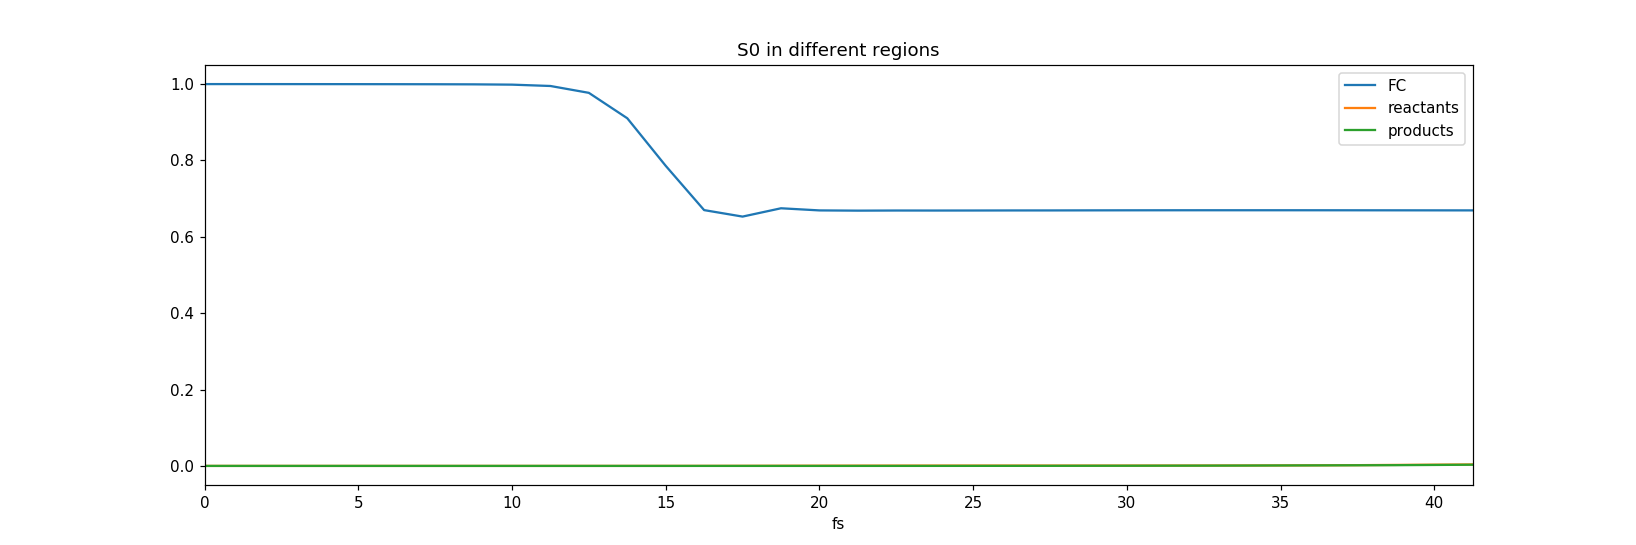

In [24]:
dataf_regions = pd.DataFrame(regions_vector, columns=labels_region)
dataf_regions['fs'] = fs_vector
dataf_regions.plot(figsize=(15,5),title = 'S0 in different regions',x=['fs']);